## Example 3: Time-dependent Simulation

**This is adapted from https://github.com/svenreiche/Genesis-1.3-Version4/tree/master/examples/Example3-TimeDependent**

Example 3, as a time-dependent simulation, differs from steady-state simulation by tracking multiple slices of the electron bunch through the undulator. This
allows to resolve a band of frequencies, depending on the sample rate of the electron slices.

**Warning** this example requires a considerable amount of memory (over 100GB) and processor cores in order to be run in a reasonable amount of time. Your laptop may not be sufficient.

By convention, a set of slices is defined in the bunch-frame, which moves with the speed of the electrons. Therefore mostly the electrons stay at the same location while the radiation slips forward, namely by one wavelength per undulator period. In Genesis4 the coordinate 
in the bunch frame is given by `s`. This shouldn't be confused with `z` which is the position in the undulator where the bunch frame is evaluated. 
In the underlying model the variable `z` acts as the independent variable of a proposed Hamiltonian.

This example is based on the steady-state input deck of Example 1. To run time-dependent simulations, the lattice file does not need to be changed. 

#### Input File

The definition of the beam-frame is done with the `&time` namelist:

```
&time
slen = 20e-6
sample = 3
&end
```

Here the total length is 20 µm, with a sample rate of 3 times the reference wavelength (defined as `gammaref` in the main `setup` namelist).

The sample rate cannot be smaller than 1 but can be increased as long as the sample rate is still smaller than the cooperation length. The choice of the sample rate also defines the spectral bandwidth according to Nyquist theorem. For the maximum sample rate the frequency is +/-50% around the central frequency. 

With a larger sample rate, the bandwidth is restricted to `+/- 50/sample` percent.  Due to the underlying solver, the FEL must be well within the given bandwidth of the simulation. Genesis does not verify that this is the case, so it is up to you.  An example of such a scenario would be a simulation with a very large energy chirp in the electron beam or seed signal that is very different from the central frequency. On the other hand, the resonant frequency of the FEL does not need to be exactly the same as the central frequency.

There is also one possible pitfall that the desired integration step size is not in conflict with the sample rate. This example configures an integration step size of 45 mm, which corresponds to three undulator periods. This means that after one single integration step, the field is pushed three wavelength.

If the sample rate is smaller (e.g., `sample = 1`), then after one integration step the field jumps over electron slices without interaction.
As an example for `sample = 1` the field in slice is copied from slice `i` to slice `i+3`.  There is no interaction with slice `i+1` and `i+2`. As a consequence, the simulation acts as three independent simulations with a sample rate of `3`.  For this reason the example uses a sample rate of `3`.

To illustrate a time-varying input parameter, we set up the simulation for a Gaussian current profile and a linear chirp.

For that some profiles are defined with 
```asm
&profile_gauss
label=current
c0 = 2500
s0 = 10e-6
sig = 6e-6
&end

&profile_polynom
label=energy
c0=11347.
c1=1e7.
&end
```
The upper is the current profile with an rms length of 6 microns. Since the beam frame is defined for 20 microns, starting at s=0 micron. The peak of the Gaussian is placed at s=10 microns with the `s0` parameter.

The lower namelist is the energy chirp of the electron bunch. That namelist supports higher polynomial order but the corresponding coefficent are defaulting to zero.
Here only the constant and linear term is defined.

To assign these profiles to the beam parameters they are referred to by their name:

```asm
&beam
current=@current
gamma = @energy
...
&end
```

Time-simulation using much more resources than steady-state simulation and sufficient memory much be provided for storing the entire beam and field in memory.
Also the output files can be very large. Therefore it is better to reduced them.
One method is to only generate output after a given count of integration step. This is done in the track namelist with:

```asm
&track
output_step=3
&end
```
In this case after each 3rd integration step there will be an output

The other method is to exclude certain fields in the output in combination for a collective output of all slices, such as the mean energy in the electron beam.

This is configured in the setup namelist:

```asm
&setup
...
field_global_stat = true
beam_global_stat = true
exclude_spatial_output = true
exclude_fft_output = true
&end
```

`exclude_spatial_output` supresses any spatial information (cente rposition and rms sizes) while `exclude_fft_output` affects the field divergence. The simulation runs a little bit faster with this configured since the 2D FFT of the field wave-fronts can be CPU intensive.

Global stats parameters can be found in the HDF5 group `/Global` in the corresponding field or beam group.

The last step to run a SASE simulation to set the radiation power to zero and set the `shotnoise` parameter in the `setup` namelist to `1`.

In [2]:
import matplotlib.pyplot as plt
import numpy as np

from genesis.version4 import Genesis4

%config InlineBackend.figure_format = 'retina'  # Nicer plots

## Running the simulation

Since the simulation is tracking thousands of slice instead of a single slice for steady-state simulation, Genesis should be started with the `mpirun` command and run on multiple cores.

Here, we tell Genesis4 to automatically detect our core count and use MPI if available.

The number of cores chosen by MPI will be shown in the output:
```
MPI-Comm Size: 12 nodes
```
This indicates it will be parallelized across 12 cores.

In [3]:
G = Genesis4("data/example3-timedependent/Example3.in")
G.nproc = 96
G.verbose = True

In [4]:
output = G.run()

Configured to run in: /tmp/tmpc8kqzegy
Setting use_mpi = True because nproc = 96
Running Genesis4 in /tmp/tmpc8kqzegy
mpirun -n 96 genesis4 -l Example3.lat genesis4.in
---------------------------------------------
GENESIS - Version 4.6.6 has started...
Compile info: Compiled by conda at 2024-01-11 18:02:26 [UTC] from Git Commit ID: 226c27d5b1b045a8195218d2ce5d63aaa10537c7
Starting Time: Wed May 22 16:17:15 2024

MPI-Comm Size: 96 nodes

Opened input file genesis4.in
Parsing lattice file Example3.lat ...
Matching for periodic solution between z = 0 and z = 9.5 :
   betax (m) : 8.53711
   alphax    : -0.703306
   phix (deg): 45.818
   betay (m) : 17.3899
   alphay    : 1.40348
   phiy (deg): 45.818
Setting up time window of 20.016 microns with 66720 sample points...
Adding profile with label: current
Adding profile with label: energy
Generating input radiation field for HARM = 1 ...
Generating input particle distribution...

Running Core Simulation...
Time-dependent run with 66720 slices

## Output

The output is similar to the steady-state simulation except some informations are added on the number of slices and the resulting beam-frame size.

Since the MPI execution of Genesis requires a symmetric number of slices per node it might not be able to resolve the requested size of the beam-frame.
To solve this Genesis will add that many slices to the last node that it holds the same amount as the others. This causes an extension of the time-window. This depends on the number of modes chosen.

In addition the shotnoise depends on the number of modes, where 1000 slices are resolved by 20 or 50 nodes. This will be fixed in a future release for better reproducibility of the simulation results.



### Time-dependent beam parameters

To verify the requested shape the beam current and the energy at the simulation start is plotted.


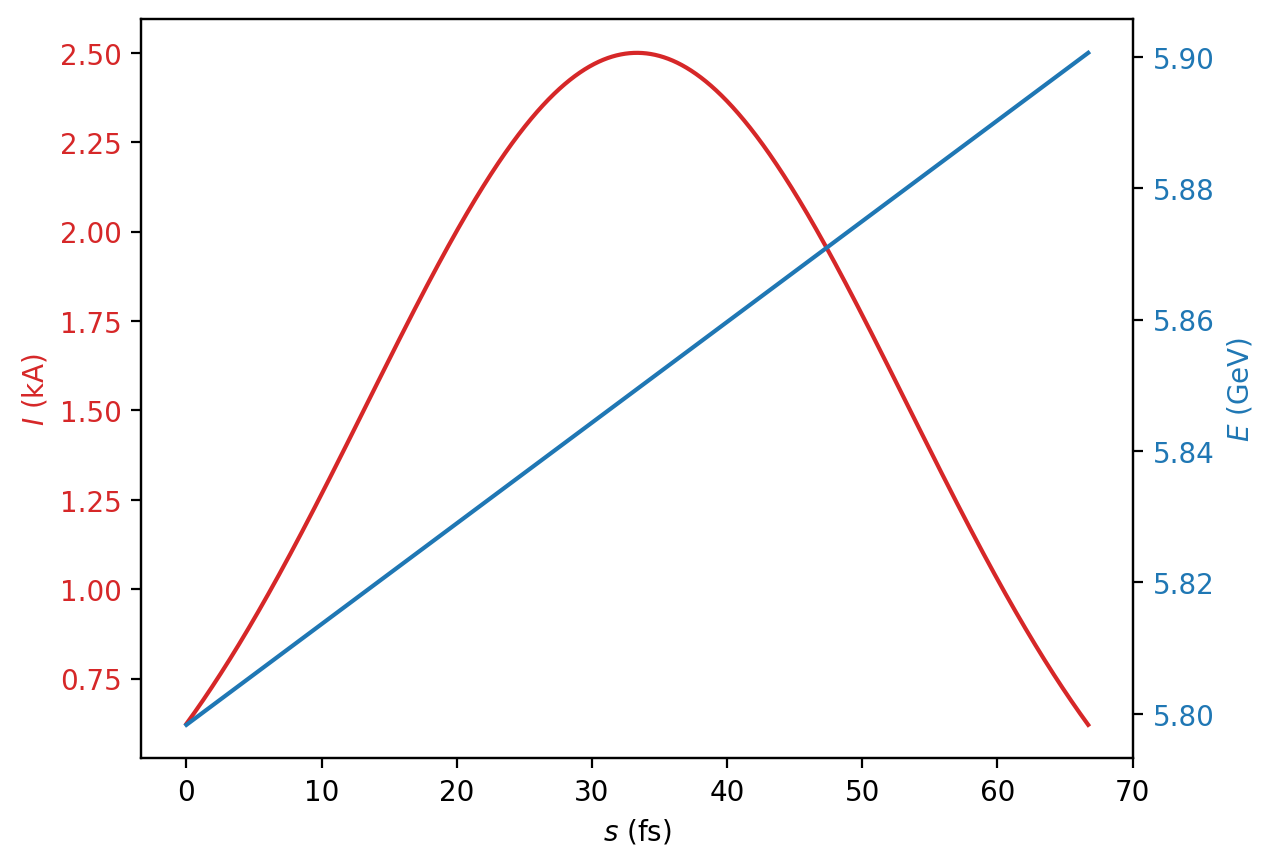

In [16]:
# plot beam parameters - current profile and energy
s = output.global_.s / 3e8 * 1e15
current = output.beam.current[0, :] * 1e-3
energy = output.beam.energy[0, :] * 0.511 * 1e-3

fig, ax1 = plt.subplots()
color = "tab:red"
ax1.set_xlabel(r"$s$ (fs)")
ax1.set_ylabel(r"$I$ (kA)", color=color)
ax1.tick_params(axis="y", labelcolor=color)
ax1.plot(s, current, color=color)

ax2 = ax1.twinx()
color = "tab:blue"
ax2.set_ylabel(r"$E$ (GeV)", color=color)
ax2.tick_params(axis="y", labelcolor=color)
ax2.plot(s, energy, color=color)
plt.show()


### Pulse Energy and Far Field Intensity

The ``Field/Global`` group holds the evolution of the pulse energy and the on-axis far field intensity.
Since Genesis allows for a lot of higher transverse modes to be emitted they are included in the calculation of the pulse energy for SASE simulation. This generates the bump in the semi-log plot. Often it is hard to see if there is an exponential gain.

It is then convenient to plot the on-axis far-field intensity. Since it has no contribution from higher transverse modes it is a "cleaner" signal for the FEL process.

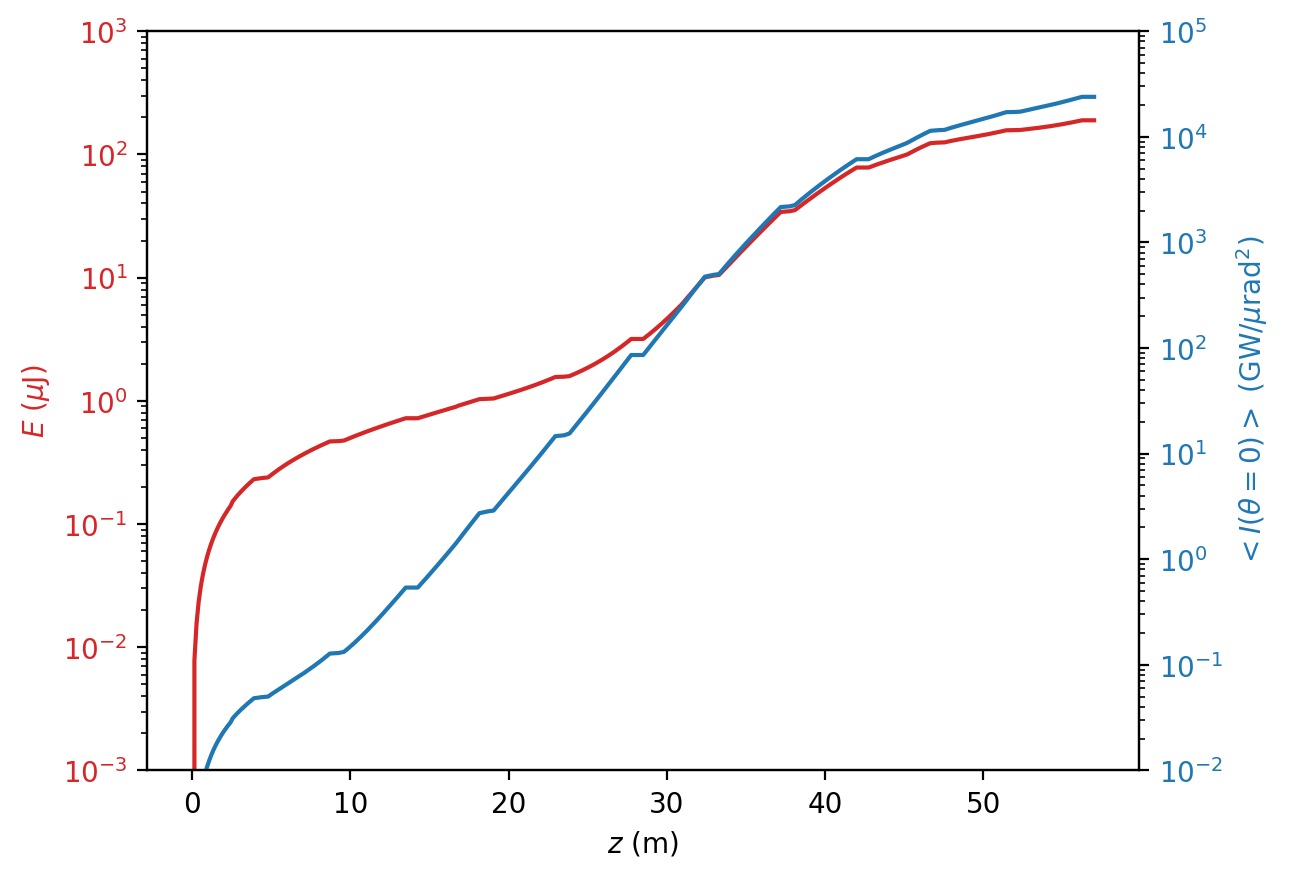

In [17]:
# plot global parameters
z = output.lattice.zplot
energy = output.field_info.global_.energy * 1e6
energy0 = energy[220]
farfield = output.field_info.global_.intensity_farfield * 1e-21

fig, ax1 = plt.subplots()
color = "tab:red"
ax1.set_xlabel(r"$z$ (m)")
ax1.set_ylabel(r"$E$ ($\mu$J)", color=color)
ax1.tick_params(axis="y", labelcolor=color)
ax1.semilogy(z, energy, color=color)
ax1.set_ylim([1e-3, 1e3])

ax2 = ax1.twinx()
color = "tab:blue"
ax2.set_ylabel(r"$<I(\theta=0)>$ (GW/$\mu$rad$^2$)", color=color)
ax2.tick_params(axis="y", labelcolor=color)
ax2.semilogy(z, farfield, color=color)
ax2.set_ylim([1e-2, 1e5])
plt.show()


### Radiation Profile

This is also visible in the profiles of the radiation power and farfield intensity. In the start-up the power follows quite closely
the current profile since it acts more like spontaneous radiation which is proportional to the current. The plot is taken after the first undulator module.


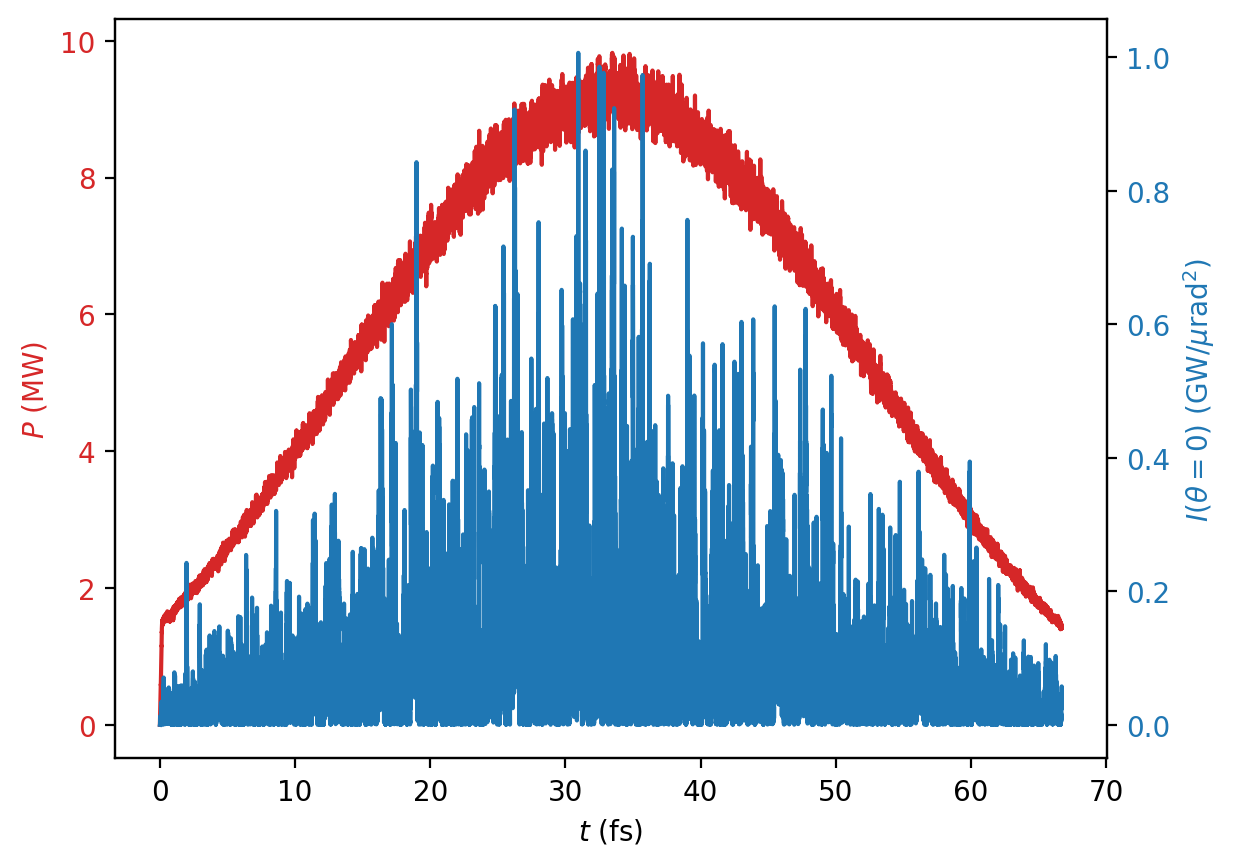

In [21]:
# power profile
power1 = output.field_info.power[50, :] * 1e-9
farfield1 = output.field_info.intensity_farfield[50, :] * 1e-24

power2 = output.field_info.power[220, :] * 1e-9
farfield2 = output.field_info.intensity_farfield[220, :] * 1e-24

fig, ax1 = plt.subplots()
color = "tab:red"
ax1.set_xlabel(r"$t$ (fs)")
ax1.set_ylabel(r"$P$ (MW)", color=color)
ax1.tick_params(axis="y", labelcolor=color)
ax1.plot(s, power1 * 1e3, color=color)
# ax1.set_ylim([1e-3,1e3])

ax2 = ax1.twinx()
color = "tab:blue"
ax2.set_ylabel(r"$I(\theta=0)$ (GW/$\mu$rad$^2$)", color=color)
ax2.tick_params(axis="y", labelcolor=color)
ax2.plot(s, farfield1 * 1e3, color=color)
# ax2.set_ylim([1e-2,1e5])
plt.show()


Further downstream the power profile has more fluctuation similar to the farfield intensity. 



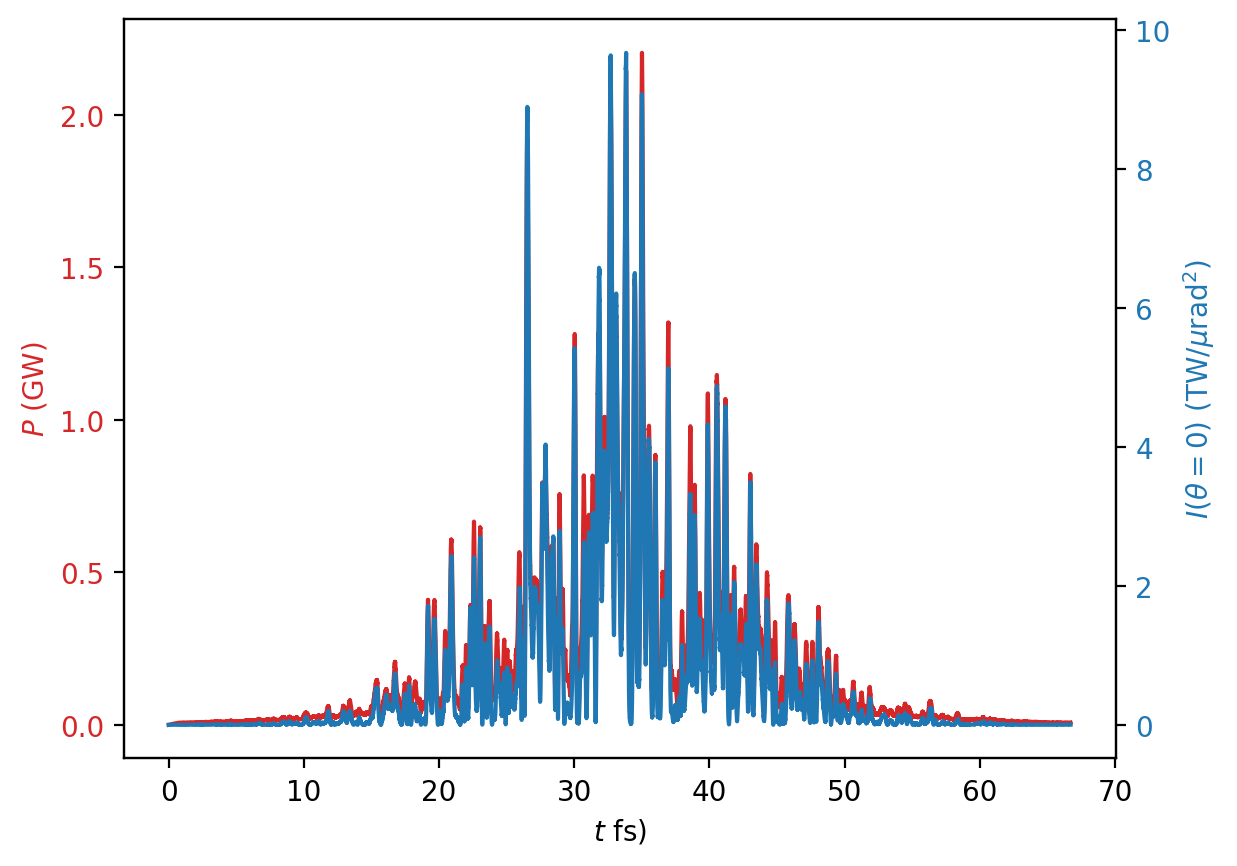

In [22]:
fig, ax1 = plt.subplots()
color = "tab:red"
ax1.set_xlabel(r"$t$ fs)")
ax1.set_ylabel(r"$P$ (GW)", color=color)
ax1.tick_params(axis="y", labelcolor=color)
ax1.plot(s, power2, color=color)
# ax1.set_ylim([1e-3,1e3])

ax2 = ax1.twinx()
color = "tab:blue"
ax2.set_ylabel(r"$I(\theta=0)$ (TW/$\mu$rad$^2$)", color=color)
ax2.tick_params(axis="y", labelcolor=color)
ax2.plot(s, farfield2, color=color)
# ax2.set_ylim([1e-2,1e5])
plt.show()

A zoom in the core part of the beam-frame shows that close at saturation the profile of power and far-field intensity has roughly the same shape.
The slight shift in the power is still causes from some parasitic higher modes and indicates that the transverse coherence is not fully at 100%.

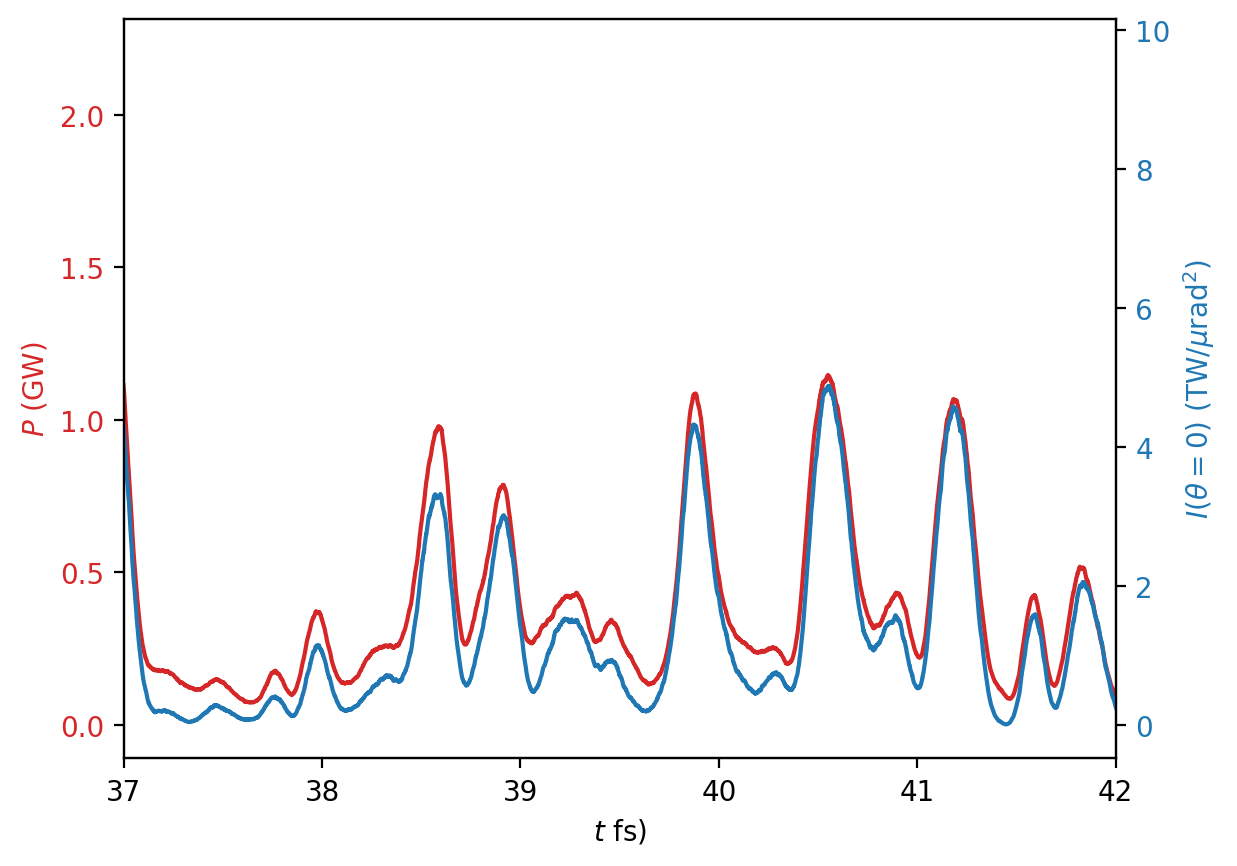

In [23]:
fig, ax1 = plt.subplots()
color = "tab:red"
ax1.set_xlabel(r"$t$ fs)")
ax1.set_ylabel(r"$P$ (GW)", color=color)
ax1.tick_params(axis="y", labelcolor=color)
ax1.plot(s, power2, color=color)
ax1.set_xlim([37, 42])
# ax1.set_ylim([1e-3,1e3])

ax2 = ax1.twinx()
color = "tab:blue"
ax2.set_ylabel(r"$I(\theta=0)$ (TW/$\mu$rad$^2$)", color=color)
ax2.tick_params(axis="y", labelcolor=color)
ax2.plot(s, farfield2, color=color)
ax2.set_xlim([37, 42])
# ax2.set_ylim([1e-2,1e5])
plt.show()

A more compact plot showing the evolution is when for each step in z the profile is normalized to its mean values. Otherwise one could not see the start-up regime with the exponential growth of 
the radiation power. In this 2D plot the spiky structure becomes apparent after about half the undulator length. These spikes more forward in the beam-frame with a group velocity which is less than the spead of light.
At saturation this changes (the slope of the spikes is slightly changed). Also after saturation the power in the head and tail can reach saturation and the pulse gets longer.


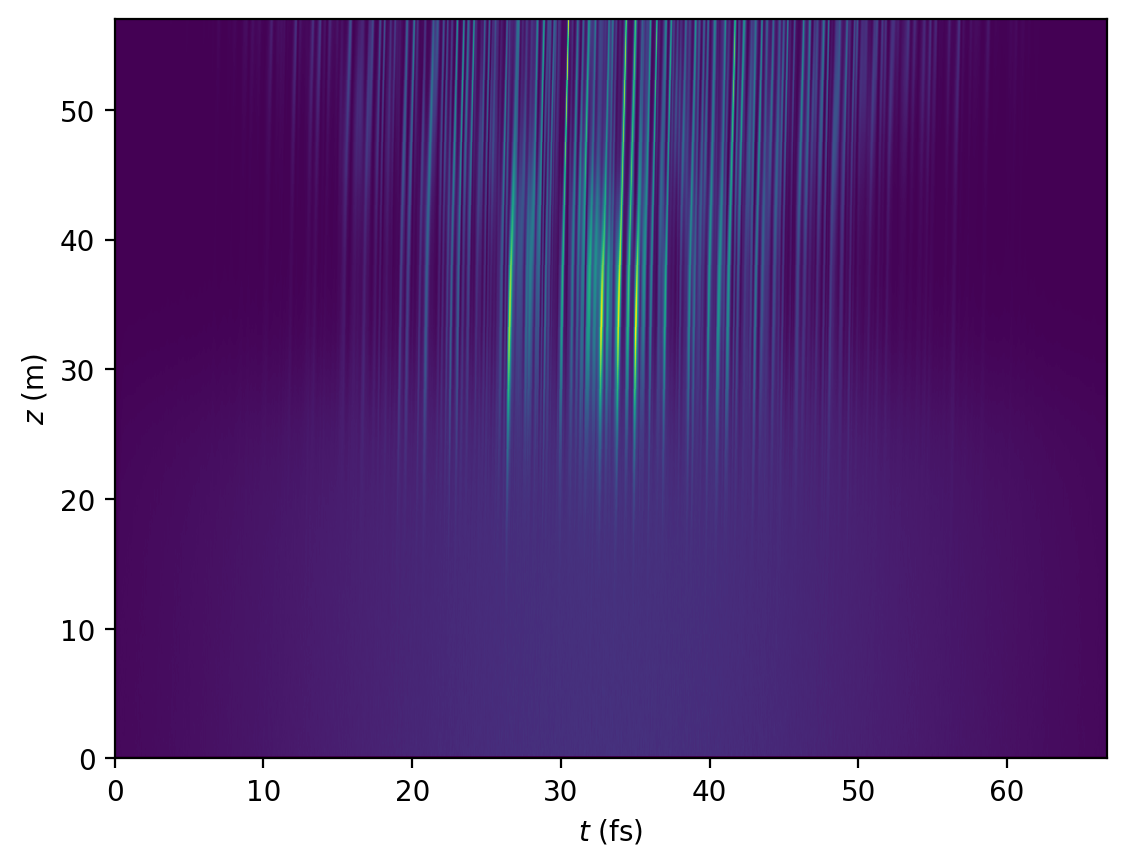

In [24]:
power = output.field_info.power
pmean = np.mean(power, axis=1)
zmean = np.mean(power, axis=1)
for i in range(len(pmean)):
    if pmean[i] == 0:
        pmean[i] = 1.0
    power[i, :] *= 1.0 / pmean[i]
plt.imshow(
    np.flipud(power),
    aspect="auto",
    interpolation="none",
    extent=(np.min(s), np.max(s), np.min(z), np.max(z)),
)
plt.xlabel(r"$t$ (fs)")
plt.ylabel(r"$z$ (m)")
plt.show()

From the farfield intensity and phase the spectrum can be calculated. In this case the spectrum is wider than expected since the beam has an intrinsic energy chirp and thus broadening the emitted frequency spectrum


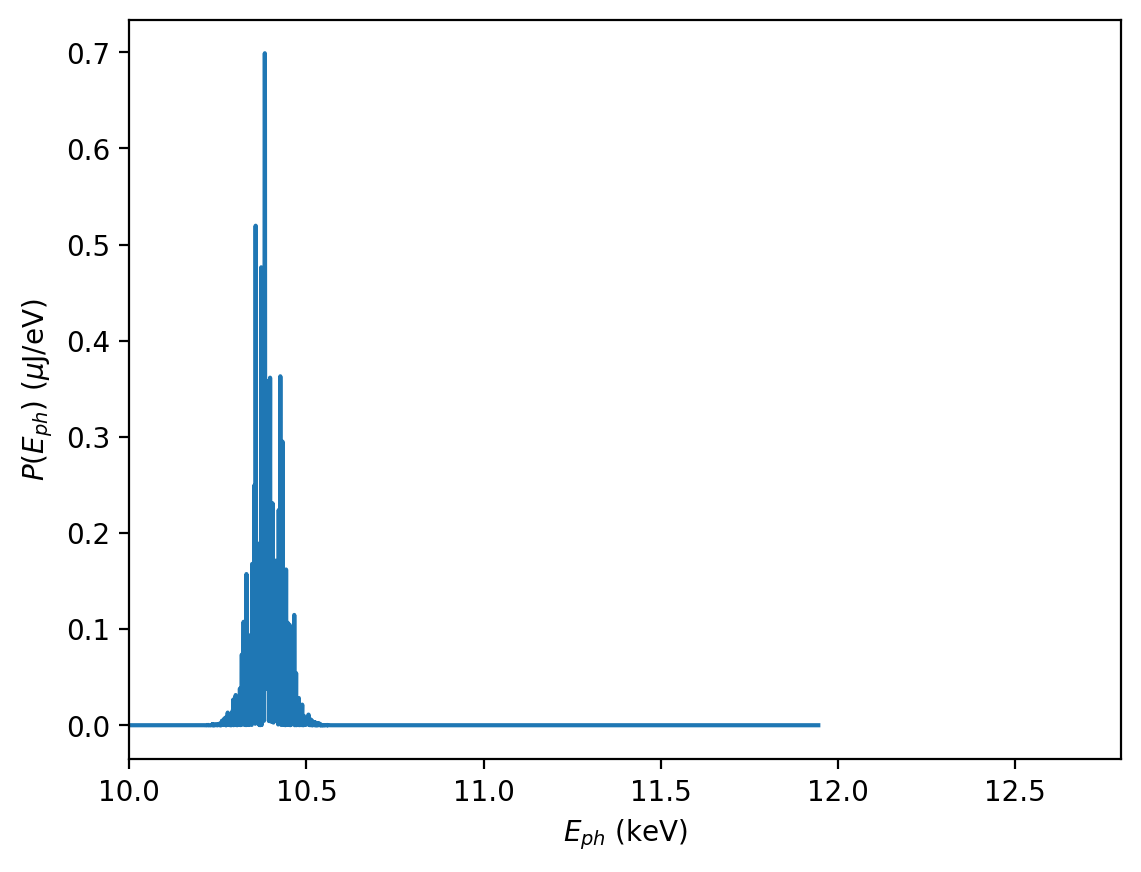

In [30]:
sig = output.field_info.intensity_farfield[220, :]
phi = output.field_info.phase_farfield[220, :]
freq = output.global_.frequency

signal = np.sqrt(sig) * np.exp(1j * phi)
spec = np.abs(np.fft.fftshift(np.fft.fft(signal))) ** 2
norm = energy0 / np.sum(spec) / (freq[1] - freq[0])
spec = norm * spec

plt.plot(freq * 1e-3, spec)
# plt.xlim([12.400, 12.800])
plt.xlim([10, 12.800])
plt.xlabel(r"$E_{ph}$ (keV)")
plt.ylabel(r"$P(E_{ph})$ ($\mu$J/eV)")
plt.show()